In [1]:
# Importing and setup
import pandas as pd
import matplotlib
import sklearn
import numpy as np
%matplotlib inline

There are 3150 samples, and 8 features.


'\nThe following interpretations can be drawn from the histograms:\n\n1. From (a), the overwhelming majority of articles (>50%) contain between 0 and 5000 characters, some (~30%) contain between 5000 and 10000 characters\n2. From (b), it can be observed that there is an even split among the data between all 9 leaf labels\n3. From (c), it can be observed that there are exactly 350 more articles with sports as the root label than climate as the root label. This makes sense because there are 5 leaf labels under sports and only 4 leaf labels under climate.\n'

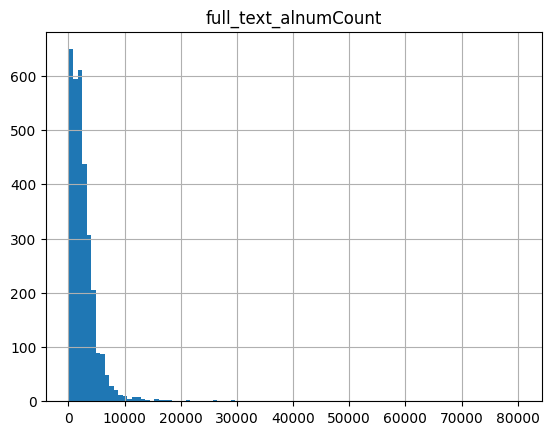

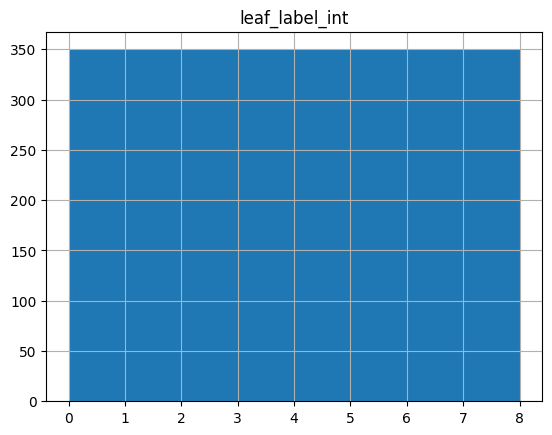

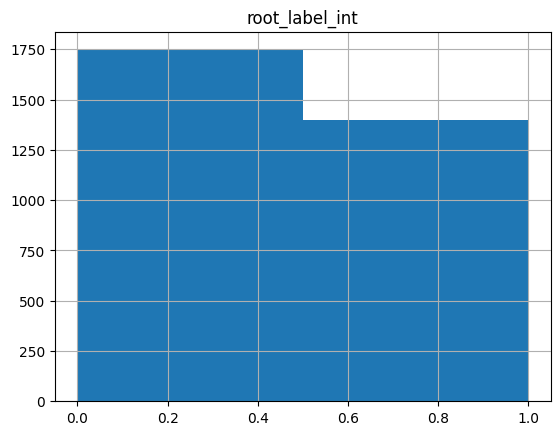

In [2]:
########## Question 1
df = pd.read_csv('Project1-Classification.csv')

########## Overview
print("There are " + str(df.shape[0]) + " samples, and " + str(df.shape[1]) + " features.")

########## Histograms
##### a
# define lambda function to count alpha-numeric characters
count_alpha_numeric = lambda s: sum(c.isalnum() for c in s)

# apply lambda function to each row of full_text
df['full_text_alnumCount'] = df['full_text'].apply(count_alpha_numeric)

# generate histogram
df.hist(column="full_text_alnumCount", bins=100)

##### b
# create a dictionary to map  labels to unique integer values
leaf_label_map = {label: i for i, label in enumerate(df['leaf_label'].unique())}

# create a new column in the DataFrame with the integer values
df['leaf_label_int'] = df['leaf_label'].map(leaf_label_map)

# generate histogram
df.hist(column="leaf_label_int", bins=9)

##### c
# create a dictionary to map  labels to unique integer values
root_label_map = {label: i for i, label in enumerate(df['root_label'].unique())}

# create a new column in the DataFrame with the integer values
df['root_label_int'] = df['root_label'].map(root_label_map)

df.hist(column="root_label_int", bins=2)

########## Interpret Plots
"""
The following interpretations can be drawn from the histograms:

1. From (a), the overwhelming majority of articles (>50%) contain between 0 and 5000 characters, some (~30%) contain between 5000 and 10000 characters
2. From (b), it can be observed that there is an even split among the data between all 9 leaf labels
3. From (c), it can be observed that there are exactly 350 more articles with sports as the root label than climate as the root label. This makes sense because there are 5 leaf labels under sports and only 4 leaf labels under climate.
"""

In [3]:
########## Question 2
import numpy as np
import random
np.random.seed(42)
random.seed(42)
from sklearn.model_selection import train_test_split
train, test = train_test_split(df[["full_text","root_label_int"]], test_size=0.2)


print("There are " + str(train.shape[0]) + " training samples and " + str(test.shape[0]) + " test samples.")

There are 2520 training samples and 630 test samples.


In [4]:
########### Question 3
train['full_text'].head(1)
# Cleaner code:
import re
def clean(text):
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    texter = re.sub(r"<br />", " ", text)
    texter = re.sub(r"&quot;", "\"",texter)
    texter = re.sub('&#39;', "\"", texter)
    texter = re.sub('\n', " ", texter)
    texter = re.sub(' u '," you ", texter)
    texter = re.sub('`',"", texter)
    texter = re.sub(' +', ' ', texter)
    texter = re.sub(r"(!)\1+", r"!", texter)
    texter = re.sub(r"(\?)\1+", r"?", texter)
    texter = re.sub('&amp;', 'and', texter)
    texter = re.sub('\r', ' ',texter)
    clean = re.compile('<.*?>')
    texter = texter.encode('ascii', 'ignore').decode('ascii')
    texter = re.sub(clean, '', texter)
    if texter == "":
        texter = ""
    return texter

# processing data by using provided cleaner code
train["cleaned"] = train['full_text'].apply(clean)
test["cleaned"] = test['full_text'].apply(clean)

# Using english stopwords of the CountVectorizer and excluding terms that are numbers with the token pattern argument
from sklearn.feature_extraction.text import CountVectorizer
pattern = r'\b[A-Za-z]+\b'
vectorizer = CountVectorizer(stop_words='english',token_pattern=pattern, min_df=3)

# Creating vector representations from the CountVectorizer created of the processed training and test data
Xtrain = vectorizer.fit_transform(train['cleaned'])
Xtest = vectorizer.transform(test['cleaned'])
ytrain = train['root_label_int'].values
ytest = test['root_label_int'].values


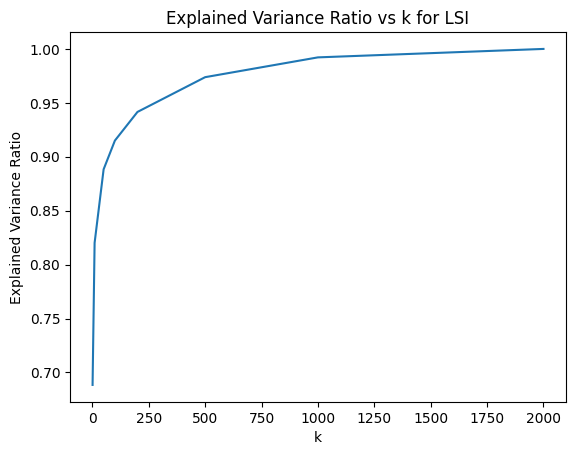

/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


KeyboardInterrupt: 

In [5]:
########## Question 4
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD, NMF

k_values = [1, 10, 50, 100, 200, 500, 1000, 2000]

# LSI
variance_ratios_lsi = []
for k in k_values:
    svd = TruncatedSVD(n_components=k, random_state=42)
    Xtrain_lsi = svd.fit_transform(Xtrain)
    variance_ratios_lsi.append(sum(svd.explained_variance_ratio_))

plt.plot(k_values, variance_ratios_lsi)
plt.title("Explained Variance Ratio vs k for LSI")
plt.xlabel("k")
plt.ylabel("Explained Variance Ratio")
plt.show()

# NMF
variance_ratios_nmf = []
for k in k_values:
    nmf = NMF(n_components=k, random_state=42)
    nmf.fit(Xtrain)
    variance_ratios_nmf.append(nmf.reconstruction_err_)

plt.plot(k_values, variance_ratios_nmf, 'o-')
plt.xlabel('Number of Components')
plt.ylabel('Reconstruction Error')
plt.title('NMF Reconstruction Error vs Number of Components')
plt.show()



SVM with gamma=1000 (hard margin):
Confusion matrix:

Accuracy: 0.9698412698412698
Precision: 0.9679434320112146
Recall: 0.9703432413671635
F1 score: 0.9690776778033526

SVM with gamma=0.0001 (soft margin):
Confusion matrix:

Accuracy: 0.9476190476190476
Precision: 0.9463678227680052
Recall: 0.9458822432424032
F1 score: 0.9461224489795919


/opt/homebrew/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


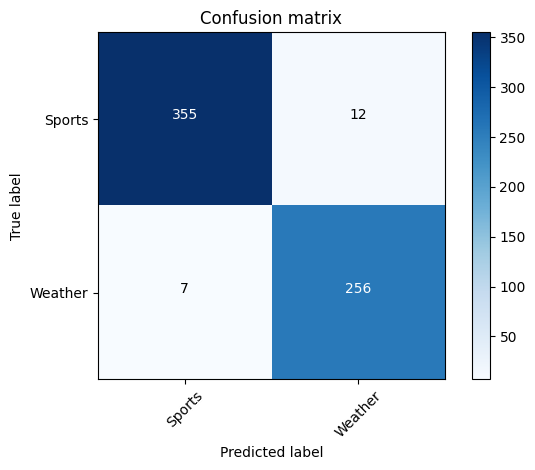

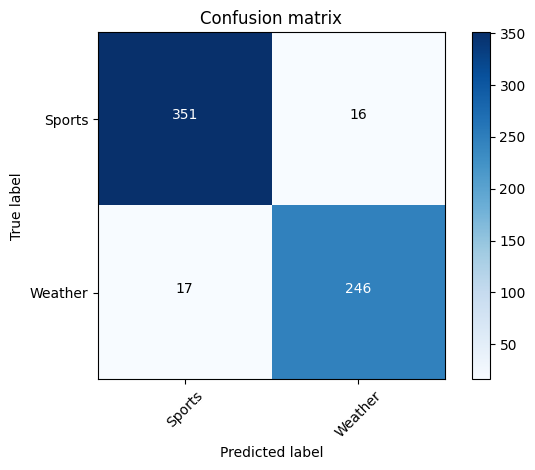

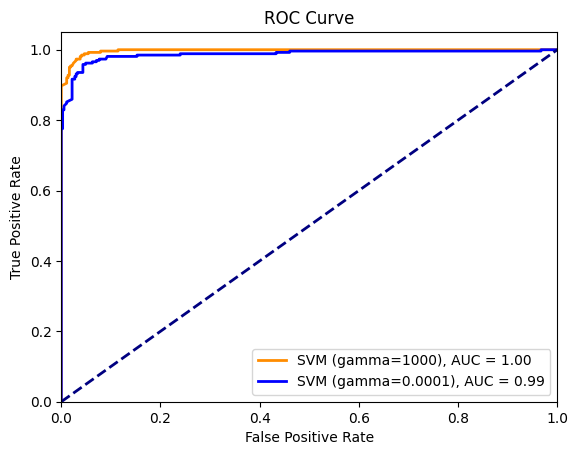

In [12]:
import itertools
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),horizontalalignment="center",color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

########## Question 5
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

# Train linear SVM with gamma=1000 (hard margin)
svm_hard = LinearSVC(C=1/1000, max_iter=10000)
svm_hard.fit(Xtrain, ytrain)

# Train linear SVM with gamma=0.0001 (soft margin)
svm_soft = LinearSVC(C=1/0.0001, max_iter=10000)
svm_soft.fit(Xtrain, ytrain)

# Predict class labels of test data using the two SVMs
y_pred_hard = svm_hard.predict(Xtest)
y_pred_soft = svm_soft.predict(Xtest)

# Evaluate performance of the two SVMs
print("SVM with gamma=1000 (hard margin):")
print("Confusion matrix:\n")
plt.figure()
plot_confusion_matrix(confusion_matrix(ytest, y_pred_hard), classes = ['Sports', 'Weather'])
print("Accuracy:", accuracy_score(ytest, y_pred_hard))
print("Precision:", precision_score(ytest, y_pred_hard, average='macro'))
print("Recall:", recall_score(ytest, y_pred_hard, average='macro'))
print("F1 score:", f1_score(ytest, y_pred_hard, average='macro'))

print("\nSVM with gamma=0.0001 (soft margin):")
print("Confusion matrix:\n") 
plt.figure()
plot_confusion_matrix(confusion_matrix(ytest, y_pred_soft), classes = ['Sports', 'Weather'])
print("Accuracy:", accuracy_score(ytest, y_pred_soft))
print("Precision:", precision_score(ytest, y_pred_soft, average='macro'))
print("Recall:", recall_score(ytest, y_pred_soft, average='macro'))
print("F1 score:", f1_score(ytest, y_pred_soft, average='macro'))

# Plot ROC curve for both SVMs
fpr_hard, tpr_hard, _ = roc_curve(ytest, svm_hard.decision_function(Xtest))
fpr_soft, tpr_soft, _ = roc_curve(ytest, svm_soft.decision_function(Xtest))
roc_auc_hard = auc(fpr_hard, tpr_hard)
roc_auc_soft = auc(fpr_soft, tpr_soft)

import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr_hard, tpr_hard, color='darkorange', lw=2, label='SVM (gamma=1000), AUC = %0.2f' % roc_auc_hard)
plt.plot(fpr_soft, tpr_soft, color='blue', lw=2, label='SVM (gamma=0.0001), AUC = %0.2f' % roc_auc_soft)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")


/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


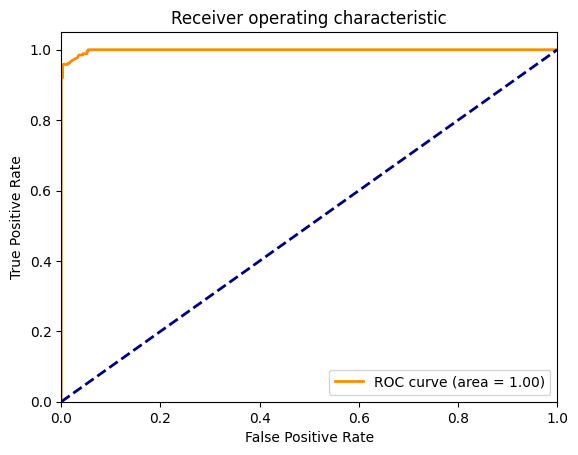

Confusion matrix:
Classification report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.98       367
           1       0.95      0.98      0.97       263

    accuracy                           0.97       630
   macro avg       0.97      0.97      0.97       630
weighted avg       0.97      0.97      0.97       630

Accuracy: 0.973015873015873


/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter 

Optimal regularization coefficient for L1 regularization:  100
Optimal regularization coefficient for L2 regularization:  0.1


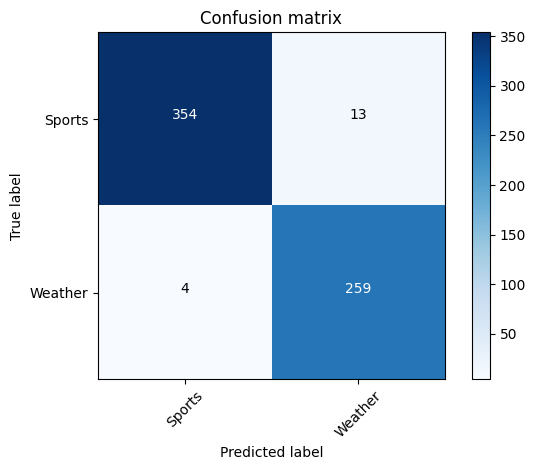